In [1]:
import pandas as pd
import numpy as np
import random
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import deque
from tqdm import tqdm
from time import time
import torch
import torch as T
import torch.nn as nn
import torch.nn.functional as F

import pickle

In [2]:
device = "cpu" #"cuda" if torch.cuda.is_available() else "cpu"

### Helper functions

In [3]:
def get_campinas_graph(dist = 1000):
    G = ox.graph_from_address('Campinas, São Paulo', network_type='drive', dist = dist)
    G = nx.convert_node_labels_to_integers(G)
    G_ = nx.DiGraph()
    for u,v,data in G.edges(data=True):
        G_.add_edge(u, v, weight=data["length"])

    for i in G.nodes:
        G_.nodes[i]["x"] = G.nodes[i]["x"]
        G_.nodes[i]["y"] = G.nodes[i]["y"]
    return G_

In [4]:
def get_source_target(G):
    random.seed(0)
    pairs = []
    for i in G.nodes:
        for j in G.nodes:
            try:
                dist = nx.shortest_path_length(G, i, j)
                if dist > 3:
                    pairs.append([i, j])
            except:
                pairs

    return random.choice(pairs)

In [5]:
def plot_all_paths_policy(G, policy, source, target):
    plt.scatter(
        [G.nodes[i]["x"] for i in G.nodes],
        [G.nodes[i]["y"] for i in G.nodes],
        alpha=0.25,
    )

    # plot the edges
    for u, v in G.edges:
        plt.plot(
            [G.nodes[u]["x"], G.nodes[v]["x"]],
            [G.nodes[u]["y"], G.nodes[v]["y"]],
            color="black",
            alpha=0.25,
        )


    for i in G.nodes:
        dest = policy[i]

        # verify if there is a edge between i and dest, if not, continue
        if (i, dest) not in G.edges:
            continue

        plt.arrow(
            G.nodes[i]["x"],
            G.nodes[i]["y"],
            (G.nodes[dest]["x"] - G.nodes[i]["x"]) * 0.7,
            (G.nodes[dest]["y"] - G.nodes[i]["y"]) * 0.7,
            alpha=0.8,
            width=0.0001,
        )

    # plot the source and target
    plt.scatter(
        [G.nodes[source]["x"], G.nodes[target]["x"]],
        [G.nodes[source]["y"], G.nodes[target]["y"]],
        color=["green", "red"],
        alpha=1,
        s=100,
    )

    # add legend to source and target with the color

    red_patch = mpatches.Patch(color="red", label="Target")
    green_patch = mpatches.Patch(color="green", label="Source")
    plt.legend(handles=[red_patch, green_patch])

    plt.xticks([])
    plt.yticks([])

def plot_value_func(agent, source, target):

    G = agent.env.G
    values = np.array([agent.argmax(i) for i in G.nodes])
    v10 = np.quantile(values, 0.1)
    v90 = np.quantile(values, 0.9)
    values = np.clip(values, v10, v90)



    plt.scatter(
        [G.nodes[i]["x"] for i in G.nodes],
        [G.nodes[i]["y"] for i in G.nodes],
        c = values,
        cmap = "magma",
        edgecolors = "k",
        zorder = 5,
        s = 80,
    )
    plt.colorbar()

    # plot the edges
    for u, v in G.edges:
        plt.plot(
            [G.nodes[u]["x"], G.nodes[v]["x"]],
            [G.nodes[u]["y"], G.nodes[v]["y"]],
            color="black",
            alpha=0.25,
        )

    # plot the source and target
    plt.scatter(
        [G.nodes[source]["x"], G.nodes[target]["x"]],
        [G.nodes[source]["y"], G.nodes[target]["y"]],
        color=["green", "red"],
        alpha=1,
        s = 140,
    )

    # add legend to source and target with the color

    red_patch = mpatches.Patch(color="red", label="Target")
    green_patch = mpatches.Patch(color="green", label="Source")
    plt.legend(handles=[red_patch, green_patch])

    plt.xticks([])
    plt.yticks([])

def plot_visits(agent, source, target):

    G = agent.env.G
    values = [agent.env.states_visits[i] for i in G.nodes]


    plt.scatter(
        [G.nodes[i]["x"] for i in G.nodes],
        [G.nodes[i]["y"] for i in G.nodes],
        edgecolors = "k",
        c = values,
        cmap = "YlOrRd",
        zorder = 5,
        s = 80,
    )
    plt.colorbar()

    # plot the edges
    for u, v in G.edges:
        plt.plot(
            [G.nodes[u]["x"], G.nodes[v]["x"]],
            [G.nodes[u]["y"], G.nodes[v]["y"]],
            color="black",
            alpha=0.25,
        )

    # plot the source and target
    plt.scatter(
        [G.nodes[source]["x"], G.nodes[target]["x"]],
        [G.nodes[source]["y"], G.nodes[target]["y"]],
        color=["green", "red"],
        alpha=1,
        s = 140,
    )

    # add legend to source and target with the color

    red_patch = mpatches.Patch(color="red", label="Target")
    green_patch = mpatches.Patch(color="green", label="Source")
    plt.legend(handles=[red_patch, green_patch])

    plt.xticks([])
    plt.yticks([])


def plot_route(G, source, target, route):
    plt.scatter(
        [G.nodes[i]["x"] for i in G.nodes],
        [G.nodes[i]["y"] for i in G.nodes],
        alpha=0.25,
    )

    plt.scatter(
        [G.nodes[source]["x"], G.nodes[target]["x"]],
        [G.nodes[source]["y"], G.nodes[target]["y"]],
        color=["green", "red"],
        alpha=1,
        s = 140,
    )


    # plot the edges
    for u, v in G.edges:
        plt.plot(
            [G.nodes[u]["x"], G.nodes[v]["x"]],
            [G.nodes[u]["y"], G.nodes[v]["y"]],
            color="black",
            alpha=0.25,
        )

    state = route[0]
    for i, next_state in enumerate(route):
        plt.arrow(
            G.nodes[state]["x"],
            G.nodes[state]["y"],
            (G.nodes[next_state]["x"] - G.nodes[state]["x"]) * 0.95,
            (G.nodes[next_state]["y"] - G.nodes[state]["y"]) * 0.95,
            alpha=0.8,
            width=0.0001,
        )
        state = next_state

    plt.xticks([])
    plt.yticks([])

def plot_agent(agent):
    fig = plt.figure(figsize = (4, 3))
    plt.plot(np.arange(len(agent.episode_rewards)), np.cumsum(agent.episode_rewards) / (np.arange(len(agent.episode_rewards)) + 1))
    plt.ylabel("Mean reward at episode")
    plt.xlabel("Episode number")
    plt.show()

    fig = plt.figure(figsize = (4, 3))
    plt.plot(agent.loss_list)
    plt.xlabel("Optim step")
    plt.ylabel("Loss")
    plt.show()

    fig = plt.figure(figsize = (4, 3))
    plot_all_paths_policy(agent.env.G, agent.policy, agent.env.source, agent.env.target)
    plt.show()

    fig = plt.figure(figsize = (4, 3))
    plot_value_func(agent, agent.env.source, agent.env.target)
    plt.title("Value function of nodes")
    plt.show()

    fig = plt.figure(figsize = (4, 3))
    plot_visits(agent, agent.env.source, agent.env.target)
    plt.title("Visit of states")
    plt.show()



### DQN Algorithm

In [6]:
class Enviroment:
    def __init__(self, G, source, target, mode = "weighted"):
        self.G = G
        self.source = source
        self.target = target
        self.mode = mode
        self.max_weight = max([G[u][v]["weight"] for u, v in G.edges])
        self.target_point = np.array([G.nodes[target]["x"], G.nodes[target]["y"]])

        x = [G.nodes[u]["x"] for u in G.nodes]
        y = [G.nodes[u]["y"] for u in G.nodes]
        self.x_range = max(x)- min(x)
        self.y_range = max(y)- min(y)
        self.diagonal_dist = np.sqrt(self.x_range**2 + self.y_range**2)
        self.dead_end_penalty = -len(G.nodes)

    def start_visits_counter(self):
        self.states_visits = dict([(i, 0) for i in self.G.nodes])

    def reset(self):
        return self.source

    def step(self, state, action):

        link = action in list(self.G[state])
        done = False

        if not link: # if not linked, stay in the same position
            reward = -1
            self.states_visits[state] +=1
            return state, reward, done
        

        if action == self.target: # if reached goal
            reward = 1000
            done = True
            self.states_visits[action] +=1
            return action, reward, done

        if len(list(self.G.neighbors(action))) == 0: # if dead end
            reward = self.dead_end_penalty
            done = True
            self.states_visits[action] +=1
            return action, reward, done

        if action == state: # if stay at the same position
            reward = -1
            done = False
            self.states_visits[action] +=1
            return action, reward, done

        


        if self.mode == "weighted":
            reward = -self.G[state][action]["weight"] / self.max_weight
        elif self.mode == "distance":
            p = np.array([self.G.nodes[action]["x"], self.G.nodes[action]["y"]])
            dist = np.linalg.norm(p - self.target_point) / self.diagonal_dist
            reward = -dist
        if self.mode == "weighted+distance":
            p = np.array([self.G.nodes[action]["x"], self.G.nodes[action]["y"]])
            dist = np.linalg.norm(p - self.target_point) / self.diagonal_dist
            reward = (- dist -self.G[state][action]["weight"] / self.max_weight)/2


        self.states_visits[action] +=1

        return action, reward, done


In [7]:
class DQN(nn.Module):
    def __init__(self, states_dim, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(states_dim, states_dim)
        self.layer2 = nn.Linear(states_dim, int(n_actions * 1.5))
        self.layer3 = nn.Linear(int(n_actions * 1.5), n_actions)
        self.layer4 = nn.Linear(n_actions, n_actions)
        self.device = device
        self.to(device)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return self.layer4(x)

    def act(self, state):
        state = state.to(device)
        actions = self.forward(state)
        action = torch.argmax(actions).item()
        return action

In [8]:
class DQNAgent:
    def __init__(
        self,
        env,
        feature_type="position",
        batch_size=32,
        gamma=0.99,
        learning_rate=1e-2,
        n_steps=100000,
        max_steps = 100,
        tau=0.005,
        avoid_invalid = False,
        verbose = True,
    ):
        self.env = env
        self.env.start_visits_counter()
        self.n_states = len(env.G.nodes)
        self.feature_type = feature_type
        if feature_type == "one_hot":
            self.online_net = DQN(self.n_states, self.n_states)
            self.target_net = DQN(self.n_states, self.n_states)
        elif feature_type == "position":
            self.online_net = DQN(self.n_states + 2, self.n_states)
            self.target_net = DQN(self.n_states + 2, self.n_states)

        self.target_net.load_state_dict(self.online_net.state_dict())
        self.optimizer = torch.optim.AdamW(
            self.online_net.parameters(), lr=learning_rate, amsgrad=True
        )

        self.gamma = gamma
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.max_steps = max_steps
        self.tau = tau
        self.replay_buffer = deque(maxlen=10000)
        self.avoid_invalid = avoid_invalid
        self.stay_state = True
        self.verbose = verbose

    def get_features(self, state):
        """Returns a vector of features for a given state"""
        if self.feature_type == "one_hot":
            vector = np.zeros(self.n_states, dtype=np.float32)
            vector[state] = 1
        elif self.feature_type == "position":
            vector = np.zeros(self.n_states + 2, dtype=np.float32)
            vector[state] = 1
            vector[-2] = self.env.G.nodes[state]["x"]
            vector[-1] = self.env.G.nodes[state]["y"]
        return vector

    def list_of_features(self, new_states_t):
        """Returns a list of vectors of features for a given list of states"""
        list_new_states_t = new_states_t.tolist()
        list_new_states_t = [int(v) for v in list_new_states_t]
        vector_list = []
        for state in list_new_states_t:
            vector = self.get_features(state)
            vector_list.append(vector)
        return np.array(vector_list)

    def verify_route(self):
        state = self.env.reset()
        route = [state]

        for _ in range(100):
            action = self.epsilon_greedy_policy(state, 0)
            state, _, done = self.env.step(state, action)
            route.append(state)
            if done:
                break

        return route[-1] == self.env.target, route

    def argmax(self, state):
        neighbors = list(self.env.G.neighbors(state))
        if len(neighbors) == 0:
            neighbors = [state]

        feature = torch.tensor([self.get_features(state)])
        if self.avoid_invalid:
            with torch.no_grad():
                feature = feature.to(self.online_net.device)
                action_values = self.online_net(feature).detach().cpu().numpy().ravel()
                not_neighbors_bool = 1 - np.isin(np.arange(self.n_states), neighbors)
                action_values[not_neighbors_bool == 1] = -np.inf
                return action_values.max()
        else:
            return self.online_net(feature).max().item()

    def epsilon_greedy_policy(self, state, epsilon):
        """Selects random action with probability epsilon, else selects action with highest Q-value"""
        rnd_sample = random.random()
        if self.stay_state:
            neighbors = list(self.env.G.neighbors(state)) + [state]
        else:
            neighbors = list(self.env.G.neighbors(state))
            if len(neighbors) == 0:
                neighbors += [state]

        if rnd_sample <= epsilon:
            if self.avoid_invalid:
                action = np.random.choice(neighbors)
            else:
                action = np.random.choice(self.env.G.nodes)
        else:
            feature = torch.tensor([self.get_features(state)])
            if self.avoid_invalid:
                with torch.no_grad():
                    feature = feature.to(self.online_net.device)
                    action_values = self.online_net(feature).detach().cpu().numpy().ravel()
                    not_neighbors_bool = 1 - np.isin(np.arange(self.n_states), neighbors)
                    action_values[not_neighbors_bool == 1] = -np.inf
                    action = np.random.choice(np.where(action_values == action_values.max())[0])
            else:
                action = self.online_net.act(feature)
        return action

    def populate_memory(self):
        """Execute greedy steps (with random network) to populate memory"""
        state = self.env.reset()
        for _ in tqdm(range(10000)):
            action = self.epsilon_greedy_policy(state, 1)
            new_state, reward, done = self.env.step(state, action)
            transition = (state, action, reward, done, new_state)
            self.replay_buffer.append(transition)
            state = new_state
            if done:
                state = self.env.reset()

    def train(self):
        self.populate_memory()
        state = self.env.reset()
        episode_reward = 0
        self.episode_rewards = [0]
        self.states_dict = []
        self.loss_list = []

        episode_route = [state]

        for step in (bar:= tqdm(range(self.n_steps))):
            epsilon = step/self.n_steps * 0.9 + 0.1
            action = self.epsilon_greedy_policy(state, epsilon)
            new_state, reward, done = self.env.step(state, action)
            transition = (state, action, reward, done, new_state)
            self.replay_buffer.append(transition)
            state = new_state
            episode_reward += reward
            episode_route.append(state)

            # if finished episode
            if done or len(episode_route) > self.max_steps:
                state = self.env.reset()
                self.episode_rewards.append(episode_reward)
                episode_reward = 0
                episode_route = []

            self.optimize_model()

            target_net_state_dict = self.target_net.state_dict()
            online_net_state_dict = self.online_net.state_dict()
            for key in online_net_state_dict.keys():
                target_net_state_dict[key] = online_net_state_dict[key]*self.tau + target_net_state_dict[key]*(1-self.tau)
            self.target_net.load_state_dict(target_net_state_dict)

            if step % 1000 == 0:
                bar.set_description(f"step: {step} - avg reward: {np.mean(self.episode_rewards):.2f}")
                reached, _ = self.verify_route()
                self.states_dict.append(
                    {"step": step, "epsilon": epsilon, "reached": reached}
                )

            if step % 10000 == 0 and pd.DataFrame(self.states_dict).reached.sum() * 1000 > 0.2 * self.n_steps:
                break

            if step % (self.n_steps // 4) == 0:
                self.stay_state = False
                route = self.get_policy_route()
                fig = plt.figure(figsize = (4, 3))
                plot_route(self.env.G, self.env.source, self.env.target, route)
                plt.title(f"Policy at step {step}")
                plt.show()
                self.stay_state = True

        self.stay_state = False

        # Organize and plot results
        self.policy = dict([(i, self.epsilon_greedy_policy(i, 0)) for i in self.env.G.nodes])
        self.states_dict = pd.DataFrame(self.states_dict)
        route = self.get_policy_route()
        fig = plt.figure(figsize = (4, 3))
        plot_route(self.env.G, self.env.source, self.env.target, route)
        plt.title(f"Final policy at step {step}")
        plt.show()

    def optimize_model(self):
        transitions = random.sample(self.replay_buffer, self.batch_size)

        # Transform transitions into tensors
        states = np.asarray([t[0] for t in transitions])
        actions = np.asarray([t[1] for t in transitions])
        rewards = np.asarray([t[2] for t in transitions])
        dones = np.asarray([t[3] for t in transitions])
        new_states = np.asarray([t[4] for t in transitions])

        states_t = torch.as_tensor(states, dtype=torch.float32).to(device)
        actions_t = torch.as_tensor(actions, dtype=torch.int64).to(device).unsqueeze(-1)
        rewards_t = torch.as_tensor(rewards, dtype=torch.float32).to(device)
        dones_t = torch.as_tensor(dones, dtype=torch.float32).to(device)
        new_states_t = torch.as_tensor(new_states, dtype=torch.float32).to(device)

        # Get argmax_a' Q(s', a')
        list_new_states_t = torch.tensor(self.list_of_features(new_states_t)).to(device)
        Q_values_target = self.target_net(list_new_states_t).max(dim=1, keepdim=False)[0]
        targets = rewards_t + self.gamma * (1 - dones_t) * Q_values_target
        targets = targets.unsqueeze(-1)

        # Get Q(s, a)
        list_states_t = torch.tensor(self.list_of_features(states_t)).to(device)
        Q_values = self.online_net(list_states_t)
        Q_values = torch.gather(input=Q_values, dim=1, index=actions_t)

        criterion = nn.SmoothL1Loss()
        loss = criterion(Q_values, targets)
        self.loss_list.append(loss.item())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def get_policy_route(self):
        state = self.env.reset()
        route = [state]
        for _ in range(100):
            action = self.epsilon_greedy_policy(state, 0)
            state, _, done = self.env.step(state, action)
            route.append(state)
            if done:
                break

        return route

## DQN tests

#### 200 radius

In [9]:
G = get_campinas_graph(200)
source, target = get_source_target(G)
print(f"Nº nodes: {len(G)}")
print(f"Source: {source} target :{target}")
print(f"Path: {nx.shortest_path(G, source, target, 'weight')}")

Nº nodes: 19
Source: 17 target :6
Path: [17, 9, 10, 2, 0, 6]


  0%|          | 0/50000 [00:00<?, ?it/s]/tmp/ipykernel_20872/2735093739.py:108: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  feature = torch.tensor([self.get_features(state)])
step: 0 - avg reward: 0.00:   0%|          | 0/50000 [00:11<?, ?it/s]

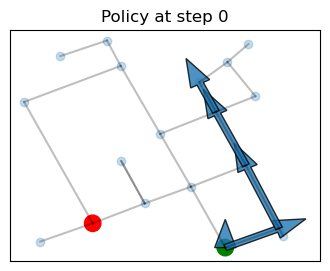

step: 12000 - avg reward: 318.60:  25%|██▍       | 12478/50000 [00:50<01:35, 391.75it/s]

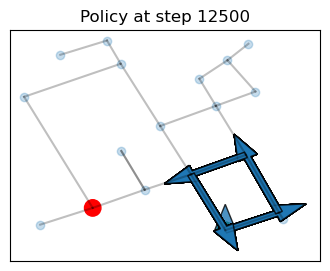

step: 25000 - avg reward: 268.97:  50%|████▉     | 24957/50000 [01:21<00:55, 450.18it/s]

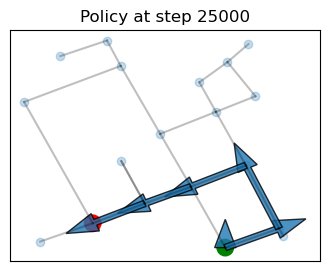

step: 37000 - avg reward: 257.41:  75%|███████▍  | 37482/50000 [01:55<00:45, 272.61it/s]

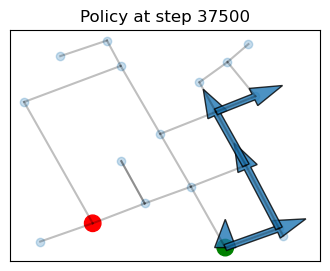

step: 49000 - avg reward: 230.78: 100%|██████████| 50000/50000 [02:28<00:00, 337.46it/s]


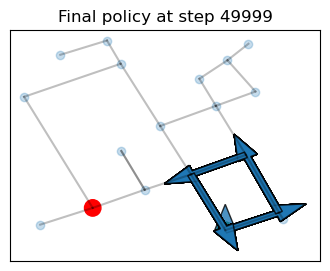

In [10]:
env = Enviroment(G, source, target, mode = "weighted")
agent = DQNAgent(
    env,
    verbose = False,
    feature_type = "position",
    n_steps = 50000,
    max_steps = len(G.nodes) /2,
    batch_size=64,
    learning_rate = 1e-3,
    avoid_invalid = True
)
agent.train()

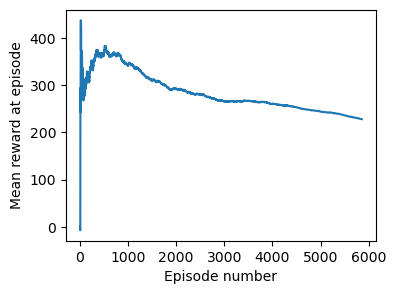

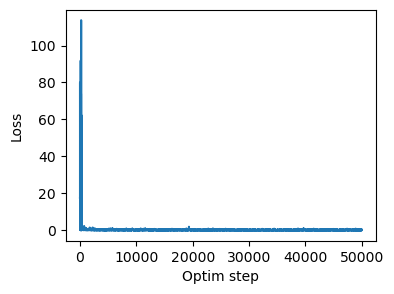

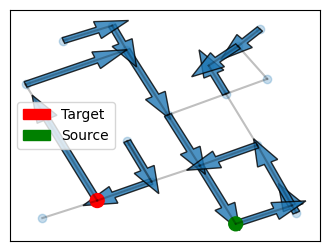

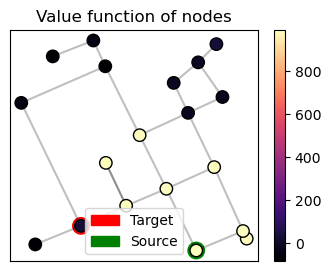

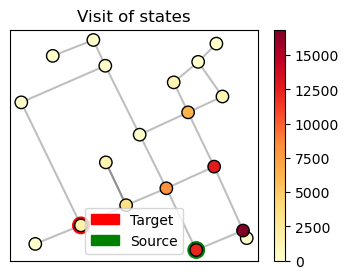

In [11]:
pickle.dump(agent, open("results/agent1_200.pkl", "wb"))
plot_agent(agent)

step: 0 - avg reward: 0.00:   0%|          | 0/50000 [00:00<?, ?it/s]

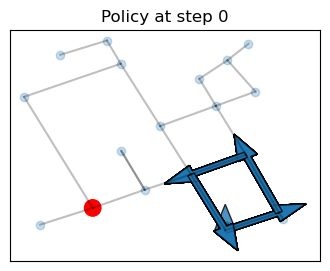

step: 12000 - avg reward: 325.39:  25%|██▍       | 12474/50000 [00:34<01:28, 422.00it/s]

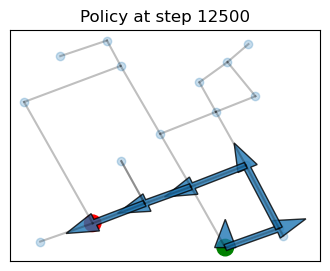

step: 25000 - avg reward: 265.03:  50%|████▉     | 24960/50000 [01:06<00:57, 438.55it/s]

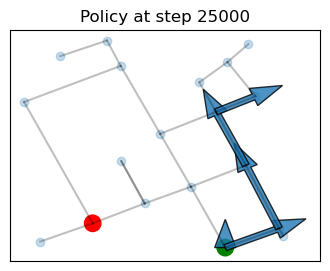

step: 37000 - avg reward: 247.17:  75%|███████▍  | 37462/50000 [01:36<00:29, 421.84it/s]

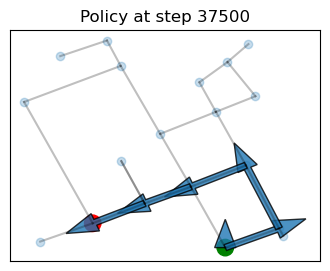

step: 49000 - avg reward: 218.80: 100%|██████████| 50000/50000 [02:06<00:00, 393.91it/s]


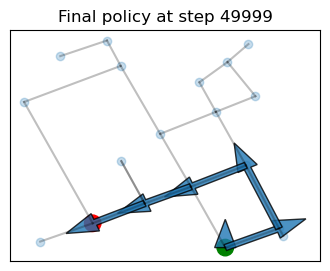

In [12]:
env = Enviroment(G, source, target, mode = "weighted+distance")
agent = DQNAgent(
    env,
    verbose = False,
    feature_type = "position",
    n_steps = 50000,
    max_steps = len(G.nodes) /2,
    batch_size=64,
    learning_rate = 1e-3,
    avoid_invalid = True
)
agent.train()

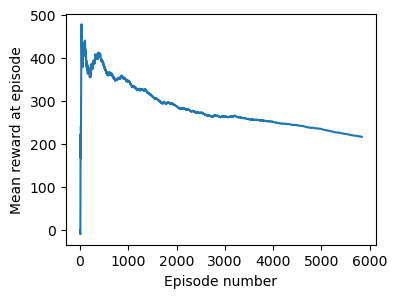

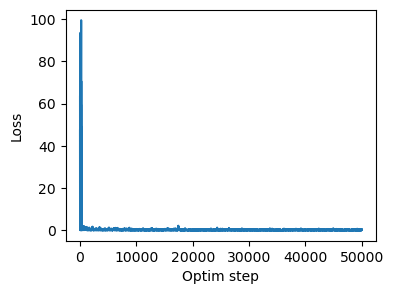

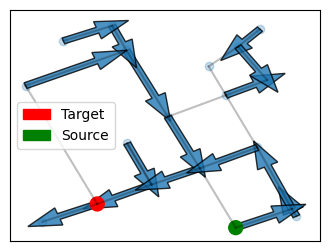

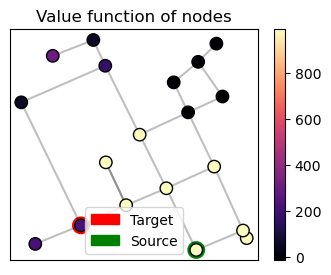

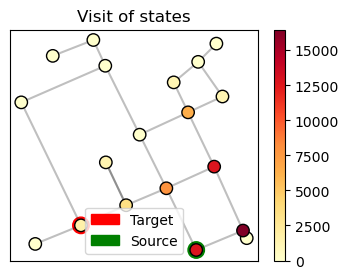

In [14]:
pickle.dump(agent, open("results/agent2_200.pkl", "wb"))
plot_agent(agent)

### Dist 400

In [15]:
G = get_campinas_graph(400)
source, target = get_source_target(G)
print(f"Nº nodes: {len(G)}")
print(f"Source: {source} target :{target}")
print(f"Path: {nx.shortest_path(G, source, target, 'weight')}")

Nº nodes: 95
Source: 39 target :80
Path: [39, 44, 26, 30, 42, 25, 53, 22, 61, 72, 24, 80]


step: 0 - avg reward: 0.00:   0%|          | 0/50000 [00:00<?, ?it/s]

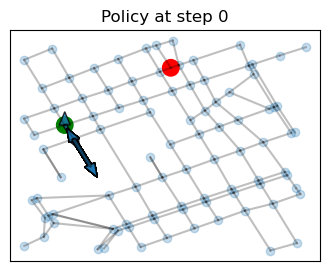

step: 12000 - avg reward: -18.62:  25%|██▍       | 12486/50000 [00:59<03:19, 187.81it/s]

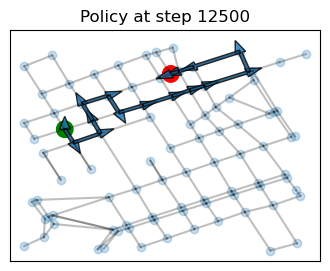

step: 25000 - avg reward: 13.25:  50%|████▉     | 24991/50000 [01:55<01:44, 238.44it/s] 

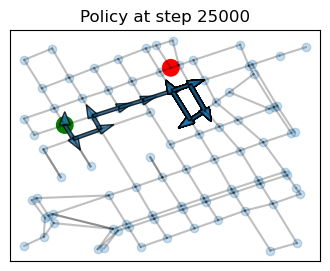

step: 37000 - avg reward: 16.48:  75%|███████▍  | 37476/50000 [02:49<00:51, 245.23it/s]

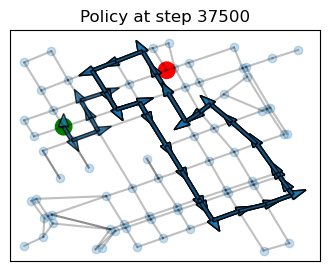

step: 49000 - avg reward: 9.55: 100%|██████████| 50000/50000 [03:46<00:00, 221.04it/s] 


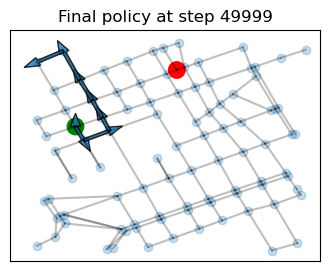

In [17]:
env = Enviroment(G, source, target, mode = "weighted")
agent = DQNAgent(
    env,
    verbose = False,
    feature_type = "position",
    n_steps = 50000,
    max_steps = len(G.nodes) /2,
    batch_size=64,
    learning_rate = 1e-4,
    avoid_invalid = True
)
agent.train()

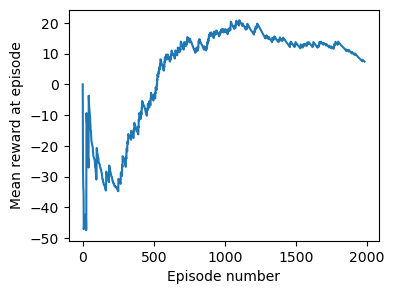

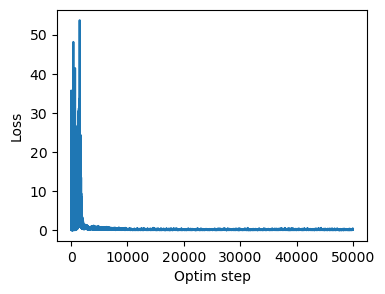

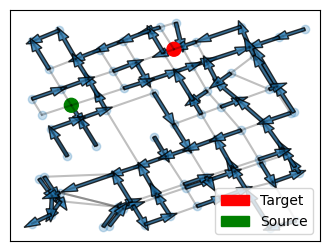

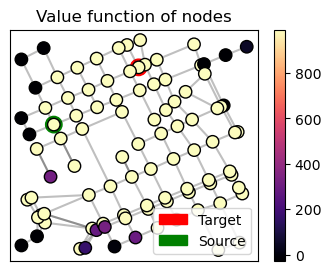

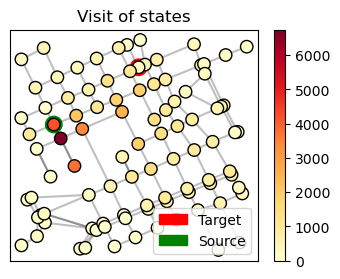

In [18]:
pickle.dump(agent, open("results/agent1_400.pkl", "wb"))
plot_agent(agent)

step: 0 - avg reward: -47.50:   0%|          | 0/50000 [00:00<?, ?it/s]

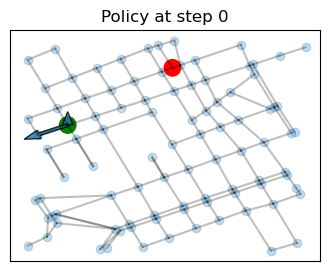

step: 12000 - avg reward: -24.79:  25%|██▍       | 12484/50000 [01:17<03:54, 159.98it/s]

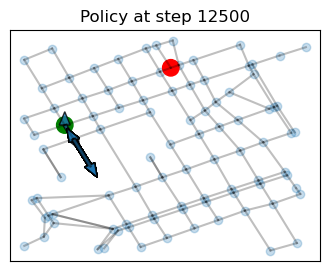

step: 25000 - avg reward: -11.51:  50%|████▉     | 24998/50000 [02:34<02:21, 176.61it/s]

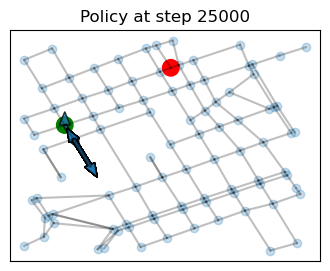

step: 37000 - avg reward: 4.10:  75%|███████▍  | 37492/50000 [03:45<00:58, 214.94it/s]  

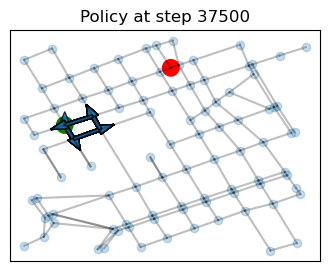

step: 49000 - avg reward: 3.81: 100%|██████████| 50000/50000 [04:42<00:00, 176.83it/s]


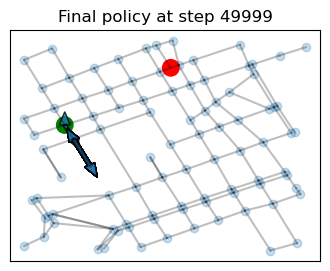

In [19]:
env = Enviroment(G, source, target, mode = "weighted+distance")
agent = DQNAgent(
    env,
    verbose = False,
    feature_type = "position",
    n_steps = 50000,
    max_steps = len(G.nodes) /2,
    batch_size=64,
    learning_rate = 1e-4,
    avoid_invalid = True
)
agent.train()

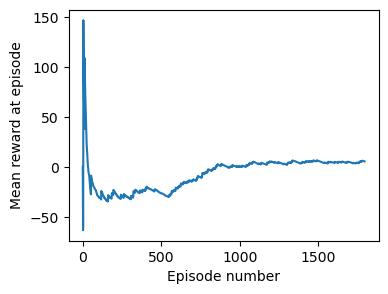

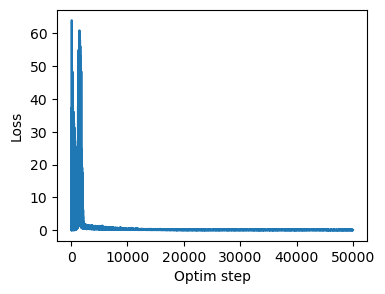

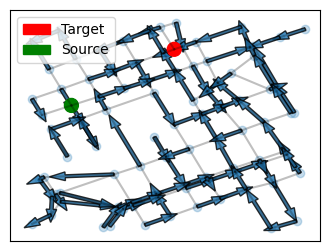

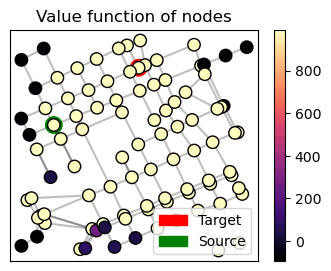

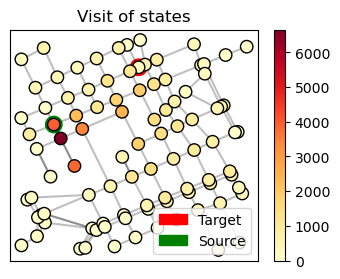

In [20]:
pickle.dump(agent, open("results/agent2_400.pkl", "wb"))
plot_agent(agent)

### Dist 600

In [21]:
G = get_campinas_graph(600)
source, target = get_source_target(G)
print(f"Nº nodes: {len(G)}")
print(f"Source: {source} target :{target}")
print(f"Path: {nx.shortest_path(G, source, target, 'weight')}")

Nº nodes: 226
Source: 137 target :188
Path: [137, 154, 116, 190, 105, 219, 220, 209, 204, 2, 188]


  0%|          | 0/10000 [00:00<?, ?it/s]

step: 0 - avg reward: 0.00:   0%|          | 0/50000 [00:00<?, ?it/s]

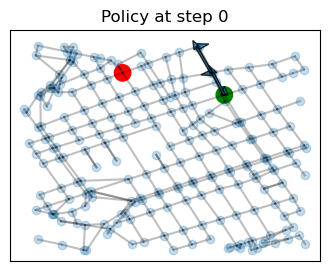

step: 12000 - avg reward: -116.64:  25%|██▍       | 12498/50000 [02:17<06:48, 91.84it/s] 

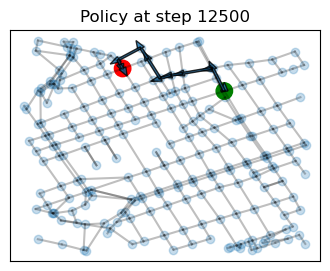

step: 25000 - avg reward: -141.61:  50%|████▉     | 24995/50000 [04:28<03:58, 104.83it/s]

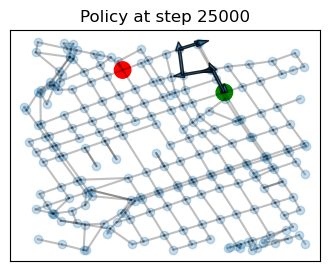

step: 37000 - avg reward: -151.29:  75%|███████▍  | 37493/50000 [06:35<01:49, 114.35it/s]

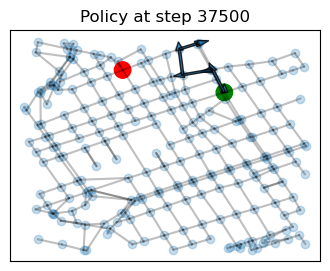

step: 49000 - avg reward: -155.23: 100%|██████████| 50000/50000 [08:24<00:00, 99.18it/s] 


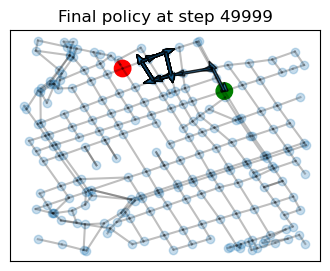

In [22]:
env = Enviroment(G, source, target, mode = "weighted")
agent = DQNAgent(
    env,
    verbose = False,
    feature_type = "position",
    n_steps = 50000,
    max_steps = len(G.nodes) /2,
    batch_size=64,
    learning_rate = 1e-4,
    avoid_invalid = True
)
agent.train()

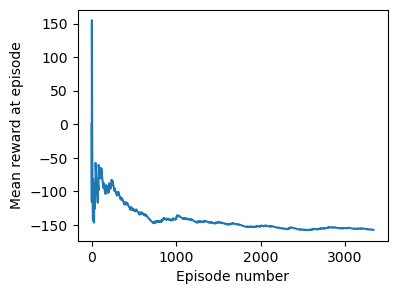

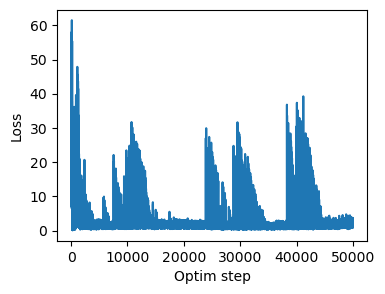

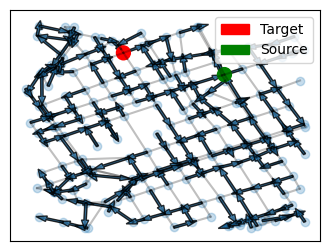

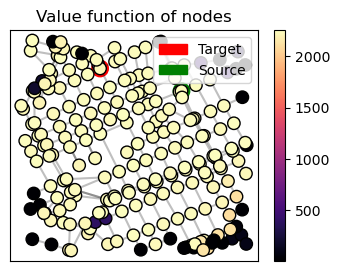

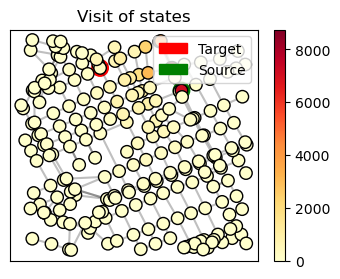

In [23]:
pickle.dump(agent, open("results/agent1_600.pkl", "wb"))
plot_agent(agent)

  0%|          | 0/10000 [00:00<?, ?it/s]

step: 0 - avg reward: 0.00:   0%|          | 0/50000 [00:00<?, ?it/s]

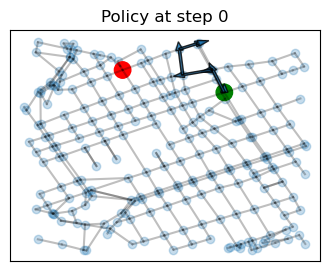

step: 12000 - avg reward: -94.29:  25%|██▍       | 12493/50000 [02:08<05:52, 106.48it/s] 

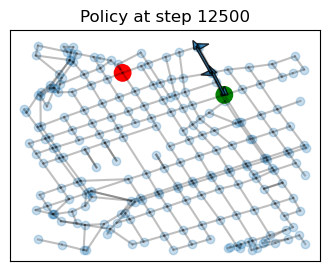

step: 25000 - avg reward: -125.44:  50%|████▉     | 24995/50000 [04:15<04:07, 100.99it/s]

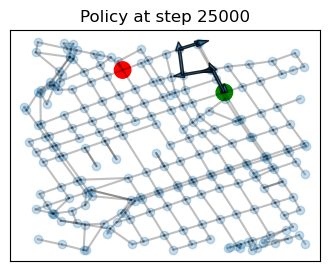

step: 37000 - avg reward: -138.61:  75%|███████▍  | 37496/50000 [06:25<02:08, 97.68it/s] 

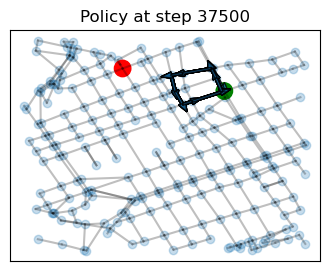

step: 49000 - avg reward: -146.86: 100%|██████████| 50000/50000 [08:25<00:00, 98.90it/s] 


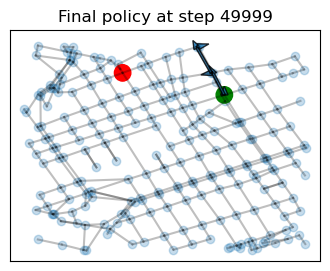

In [25]:
env = Enviroment(G, source, target, mode = "weighted+distance")
agent = DQNAgent(
    env,
    verbose = False,
    feature_type = "position",
    n_steps = 50000,
    max_steps = len(G.nodes) /2,
    batch_size=64,
    learning_rate = 1e-4,
    avoid_invalid = True
)
agent.train()

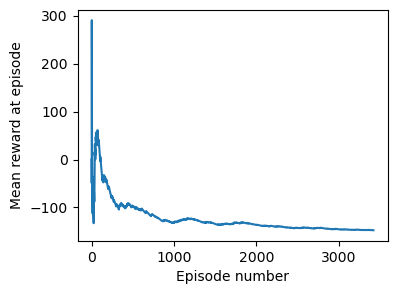

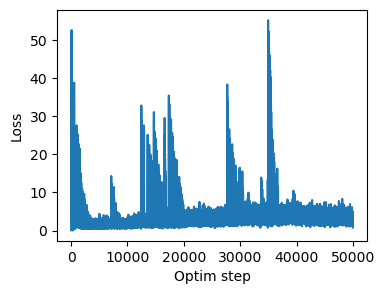

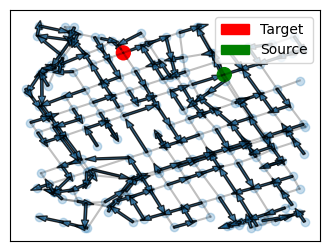

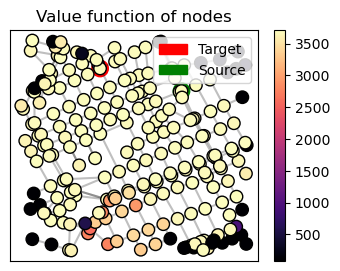

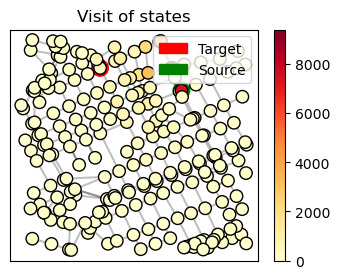

In [26]:
pickle.dump(agent, open("results/agent2_600.pkl", "wb"))
plot_agent(agent)